# Interface Optimization example.

To run interface optimization user needs to provide results from the OPS simulation. 
In particular this example is working with the file "toy_mistis_1k_OPS1.nc", which can be obtained by the command:

curl -OLk http://www.dropbox.com/s/qaeczkugwxkrdfy/toy_mistis_1k_OPS1.nc

Check the destination to the file in `test_file` 

In [1]:
# if our output file is available, use it here
import os
test_file = "toy_mistis_1k_OPS1.nc"
filename = test_file if os.path.isfile(test_file) else "mistis.nc"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpathsampling as paths

At first point we need to use standart analysis procedure to generate input data, for interface optimization.

In [3]:
storage = paths.AnalysisStorage(filename)

In [4]:
mistis = storage.networks.load(0)

In [5]:
mistis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (-0.3, 0.5) }
mistis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [6]:
# we need to load the states and the innermost interface for each transition
stateA = storage.volumes['A']
stateB = storage.volumes['B']
stateC = storage.volumes['C']
inner_AB = mistis.transitions[(stateA, stateB)].interfaces[0]
inner_AC = mistis.transitions[(stateA, stateC)].interfaces[0]
inner_BA = mistis.transitions[(stateB, stateA)].interfaces[0]

In [7]:
# got these from mistis_flux.ipynb
fluxes = {(stateA, inner_AB): 0.00134206626387,
          (stateA, inner_AC): 0.00130918783318,
          (stateB, inner_BA): 0.00129306050463}
mistis.set_fluxes(fluxes)

In [8]:
# do the analysis
mistis.rate_matrix(storage.steps, force=True)

,"({x|opX(x) in [0.3, inf]} and {x|opY(x) in [-inf, -0.3]})","({x|opX(x) in [-inf, -0.3]} and {x|opY(x) in [0.3, inf]})","({x|opX(x) in [-inf, -0.3]} and {x|opY(x) in [-inf, -0.3]})"
"({x|opX(x) in [0.3, inf]} and {x|opY(x) in [-inf, -0.3]})",NaN,NaN,2.02612e-05
"({x|opX(x) in [-inf, -0.3]} and {x|opY(x) in [-inf, -0.3]})",9.39647e-05,1.12217e-05,NaN


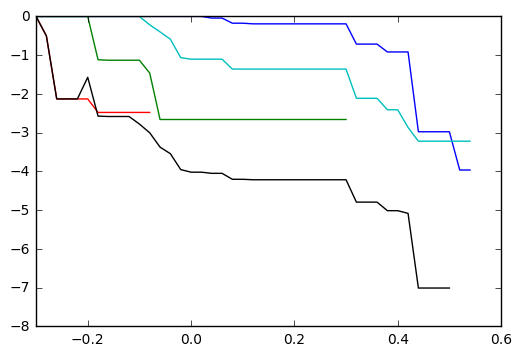

In [9]:
# visual representation of the probabilities for one of the transitions: 
trans = mistis.transitions.values()[0]
trans_hists = trans.histograms['max_lambda']
for hist in trans_hists:
    cross_prob = trans_hists[hist].reverse_cumulative()
    plt.plot(cross_prob.x, np.log(cross_prob))
plt.plot(trans.tcp.x, np.log(trans.tcp), '-k')

# TEST for the interfaces

In [10]:
# import openpathsampling.analysis.interface_optimization as io 
from paths.analysis.interface_optimization import (find_interface_and_cross,
                                                   save_n_interfaces,
                                                   save_p_interfaces,
                                                   _mapping_f)

## transition A > C

In [11]:
transitionAC = mistis.transitions[(stateA, stateC)]
# get the input data for interface-optimization analysis from transition object:
old_interfaces, old_probabilities = find_interface_and_cross(transitionAC)
# Note! if the user already has the lists containing interfaces and crossing probabilities, 
# previous step with `find_interface_and_cross` can be skipped.

In [12]:
print 'old set:', old_interfaces
print '`save_n_interfaces` usage:'
# Use `save_n_interfaces` to keep the number of interfaces the same, as in the simulation:
set_1 = save_n_interfaces(old_interfaces, old_probabilities)
print 'set 1:', set_1

# see here how to change the `formatting` of the output, using standart python commands;
# default value in both `save_n_interfaces` and `save_p_interfaces` functions is '.4g'
set_1_star = save_n_interfaces(old_interfaces, old_probabilities, formatting='.2f')
print 'set 1*', set_1_star

# `save_n_interfaces` can generate a fixed number of interfaces, if needed:
N = 6
set_2 = save_n_interfaces(old_interfaces, old_probabilities, fixed_n=N)
print 'set 2:', set_2

print '`save_p_interfaces` usage:'
# If the goal to approach crossing probability in each ensemble 
# to be equal to some fixed value, use `save_p_interfaces`:
set_3 = save_p_interfaces(old_interfaces, old_probabilities)
print 'set 3:', set_3
# Note! For this particular simulation we'll see that set_3 contains 6 interfaces, like set_2: 
# these two sets should be the same, since mapping function in the algorithm is the same for any case

# Lets increase an expected value for the crossing probability (the default is 0.4): 
p = 0.6  
set_4 = save_p_interfaces(old_interfaces, old_probabilities, p)
print 'set 4:', set_4

# for low crossing probability, like 10% (but the accuracy of the method in general will suffer from that)
# we can get shorted set of the interfaces
set_5 = save_p_interfaces(old_interfaces, old_probabilities, fixed_p=0.1)
print 'set 5:', set_5


old set: [-0.30000000000000004, -0.2, -0.1, 0.0]
`save_n_interfaces` usage:
set 1: [-0.3, -0.2317, -0.1311, 0.0]
set 1* [-0.3, -0.23, -0.13, 0.0]
set 2: [-0.3, -0.259, -0.218, -0.1568, -0.07911, 0.0]
`save_p_interfaces` usage:
set 3: [-0.3, -0.259, -0.218, -0.1568, -0.07911, 0.0]
set 4: [-0.3, -0.2772, -0.2545, -0.2317, -0.2089, -0.174, -0.1311, -0.0879, -0.04395, 0.0]
set 5: [-0.3, -0.1954, 0.0]


Now its up to the user to decide either restart simulation with new interfaces, or keep the old ones.

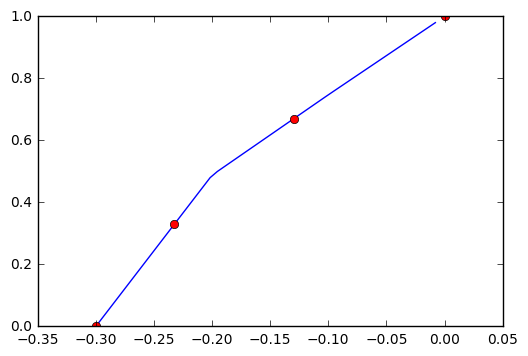

In [29]:
# here we plot the mapping function for this simulation output
# lets consider a case with 4 interfaces in the output
func = _mapping_f(old_interfaces, old_probabilities)
# 4 output interfaces are at `int4`
prob4 = [0, 0.33, 0.67, 1.0]
int4 = [func(prob) for prob in prob4]

# plot all mapping function
bins = 50
y = [float(i)/bins for i in range(bins)]
x = [func(prob) for prob in y]

plt.plot(x, y, '-')
plt.plot(int4, prob4, 'ro')
plt.show()

## remaining transitions AB and BA:

In [30]:
transitionAB = mistis.transitions[(stateA, stateB)]
transitionBA = mistis.transitions[(stateB, stateA)]

In [31]:
old_int_AB, old_prob_AB = find_interface_and_cross(transitionAB)

save_n = save_n_interfaces(old_int_AB, old_prob_AB)
save_p = save_p_interfaces(old_int_AB, old_prob_AB)
print '1) old set: \n{}\n' \
      '2) fixed N: \n{}\n' \
      '3) fixed p=0.4: \n{}\n'.format(old_int_AB, save_n, save_p)

1) old set: 
[-0.30000000000000004, -0.2, -0.1]
2) fixed N: 
[-0.3, -0.173, -0.1]
3) fixed p=0.4: 
[-0.3, -0.1973, -0.1487, -0.1]



In [33]:
old_int_BA, old_prob_BA = find_interface_and_cross(transitionBA)

In [34]:
old_int_BA, old_prob_BA = find_interface_and_cross(transitionBA)

save_n = save_n_interfaces(old_int_BA, old_prob_BA)
save_p = save_p_interfaces(old_int_BA, old_prob_BA)
print '1) old set: \n{}\n' \
      '2) fixed N: \n{}\n' \
      '3) fixed p=0.4: \n{}\n'.format(old_int_AB, save_n, save_p)

1) old set: 
[-0.30000000000000004, -0.2, -0.1]
2) fixed N: 
[-0.3, -0.183, -0.1]
3) fixed p=0.4: 
[-0.3, -0.2497, -0.1996, -0.1664, -0.1332, -0.1]

